In [1]:
import os
import sys
#set adequate flag for Theano
import theano
theano.config.gcc.cxxflags = '-march=corei7'
#check config
import keras.backend as K
K.set_image_dim_ordering('th')
#print 'Keras backend:', K.backend()
#print 'Keras image ordering operator: ', K.image_dim_ordering()
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import ROOT
import itertools
import math
from UserFunctions import *
import cPickle as pickle

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


Welcome to JupyROOT 6.07/07


In [2]:
#load events
filein = open('hzz4l_vbf_selection_noDjet_m4l118-130GeV_shuffledFS_JetExtraInfo.pkl','r')
events = pickle.load( filein )
filein.close()

In [3]:
events = prepareJetComponents(events)

In [4]:
#shifts the subjets towards the highest pt subjet
#eta'_i = eta_i - eta_0
#phi'_i = phi_i - phi_0
def translate(x, y):
    xShift = []
    yShift = []
    
    xCenter = x[0]
    yCenter = y[0]
    for ix, iy in zip(x, y):
        xShift.append( ix - xCenter )
        yShift.append( iy - yCenter )
    
    return xShift, yShift

In [5]:
#rotation not applied directly on eta-phi plane to preserve Lorentz invariances
#the rotation is likely done around px
def rotate(x,y,w):
    #defines subjets based on reclustering the PF candidates from PF jet
    #ak4PFJetCHS->R=0.4, so I adopt the half of it
    radius = 0.2
    maxPt = -1
    v = 0
    for ix, iy, iw, in zip(x, y, w):
        dR = math.sqrt( math.pow(ix - x[0], 2) + math.pow(iy - y[0], 2) )
        pt = iw
        if dR > radius and pt > maxPt:
            maxPt = pt
            py = pt*math.sin(iy)
            pz = pt*math.sinh(ix)
            v = np.arctan2(py,pz) + np.radians(90)

    rot_x = []
    rot_y = []
    #creates a rotation matrix
    c, s = np.cos(v), np.sin(v)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    for ix, iy, iw in zip(x, y, w):
        #original components
        px = iw*math.cos(iy)
        py = iw*math.sin(iy)
        pz = iw*math.sinh(ix)

        #transforms components
        #rot = [[py.cos(v) - pz.sin(v)],
        #       [py.sin(v) + pz.cos(v)]]
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        
        rot_x.append(rix)
        rot_y.append(riy)
        
    return rot_x, rot_y

In [6]:
#accounts for assymetry on energy distribution
#keeps the jet average pt always in eta' positive range
def reflect(x, w):
    leftSum = 0
    rightSum = 0
    for ix, iw in zip(x, w):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
    if(leftSum > rightSum):
        ref_x = [e*(-1) for e in x]
        return ref_x
    else:
        return x

In [7]:
#according to https://arxiv.org/abs/1704.02124 returns similar calorimeter resolution
#nx size of image in eta
#ny size of image in phi
def prepareImages(events, imc, nx, xmin, xmax, ny, ymin, ymax, pre_process):        
    list_x = [[],[],[]]
    list_y = [[],[],[]]
    list_w = [[],[],[]]

    #determines the pixel of picture
    xbins = np.linspace(xmin,xmax,nx+1)
    ybins = np.linspace(ymin,ymax,ny+1)
    #creates an empty 'th2'
    jet_images = np.zeros((len(events[imc]), 3, nx, ny))

    #group eta/phi/pt by jet
    print ik," has ", len(events[imc])," figures..."
    for iev in range(len(events[imc])):
        #if(iev > 100):
        #    break
        for ijet in range(len(events[imc][iev])):
            #check if there's a jet
            if(len(events[imc][iev][ijet][0]) == 0):
                continue
            # relative eta
            x = events[imc][iev][ijet][0]
            # relative phi
            y = events[imc][iev][ijet][1]
            # pt of candidate is the weight
            pt = events[imc][iev][ijet][2]
        
                
            #shifts the jet image to the center in (eta,phi) = (0,0)
            if(pre_process[0]):
                x, y = translate(x, y)

            #applies the rotation processing
            if(pre_process[1]):
                x, y = rotate(x, y, pt)
                        
            #applies the reflection processing
            if(pre_process[2]):
                x = reflect(x, pt)

            #applies normalization
            if(pre_process[3]):
                sumPt = sum(pt)
                if(sumPt == 0):
                    sumPt = 1
                nweights = []
                for iw in (pt):
                    nweights.append( iw/sumPt )
                pt = nweights
    
            list_x[ijet].append(x)
            list_y[ijet].append(y)
            list_w[ijet].append(pt)
            hist, xedges, yedges = np.histogram2d(x, y, weights=pt, bins=(xbins, ybins))
            for ix in range(0,nx):
                for iy in range(0,ny):
                    jet_images[iev,ijet,ix,iy] = hist[ix,iy]
                                        
    return jet_images, list_x, list_y, list_w, xbins, ybins

In [8]:
#check if DR is really satisfied
def passDR(eta_i, phi_i, eta_j, phi_j):
    #R = 0.4
    dij = min(1.0/(pt_i*pt_i), 1.0/(pt_j*pt_j)) * (math.pow(eta_i-eta_j,2)+math.pow(phi_i-phi_j,2)) * (1.0/(R*R))
    #dij = math.sqrt((math.pow(eta_i-eta_j,2)+math.pow(phi_i-phi_j,2)))
    
    return dij

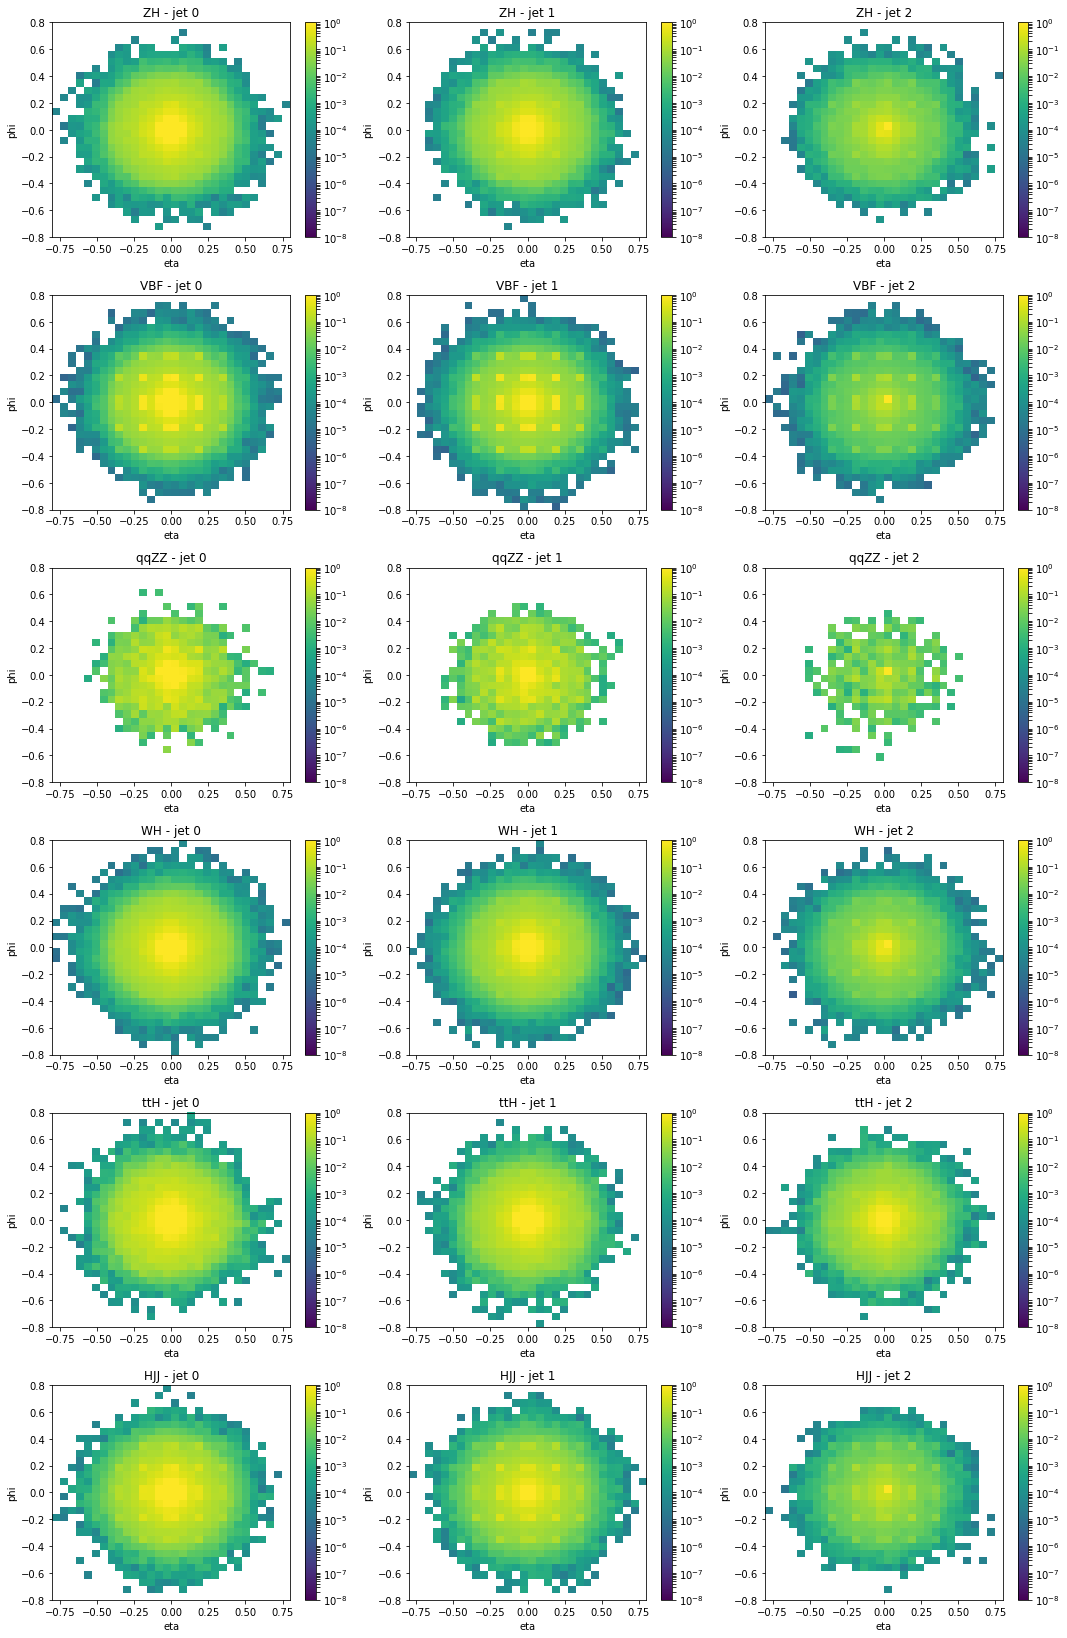

ZH  has  8908  figures...
VBF  has  38014  figures...
qqZZ  has  209  figures...
WH  has  21200  figures...
ttH  has  4253  figures...
HJJ  has  7203  figures...


In [9]:
fig = pyp.figure()
fig.set_figheight(30)
fig.set_figwidth(15)

#defines pixels
nx = 30
ny = 30
proc = [True,False,False,False]

jets_images = {}
lists_x = {}
lists_y = {}
lists_w = {}
xbins = {}
ybins = {}

ip = 0
for ik in events:
    jets_images[ik] = []
    lists_x[ik] = []
    lists_y[ik] = []
    lists_w[ik] = []
    xbins[ik] = []
    ybins[ik] = []

    #create and show jet images
    jets_images[ik], lists_x[ik], lists_y[ik], lists_w[ik], xbins[ik], ybins[ik] = prepareImages(events, ik, nx, -0.8, 0.8, ny, -0.8, 0.8, proc)

    for ich in range(3):
        all_x = np.concatenate(lists_x[ik][ich])
        all_y = np.concatenate(lists_y[ik][ich])
        all_w = np.concatenate(lists_w[ik][ich])
        all_w = 1.*all_w/len(lists_w[ik][ich]) # to get average

        ip += 1
        fig.add_subplot(8, 3, ip)
        pyp.hist2d(all_x, all_y, weights=all_w, bins=(xbins[ik],ybins[ik]), norm=mpl.colors.LogNorm(), vmin=1.e-8, vmax=1)
        pyp.colorbar()
        pyp.xlabel('eta')
        pyp.ylabel('phi')
        pyp.title( '%s - jet %i' % (ik,ich) )

pyp.tight_layout()
fig = pyp.show()

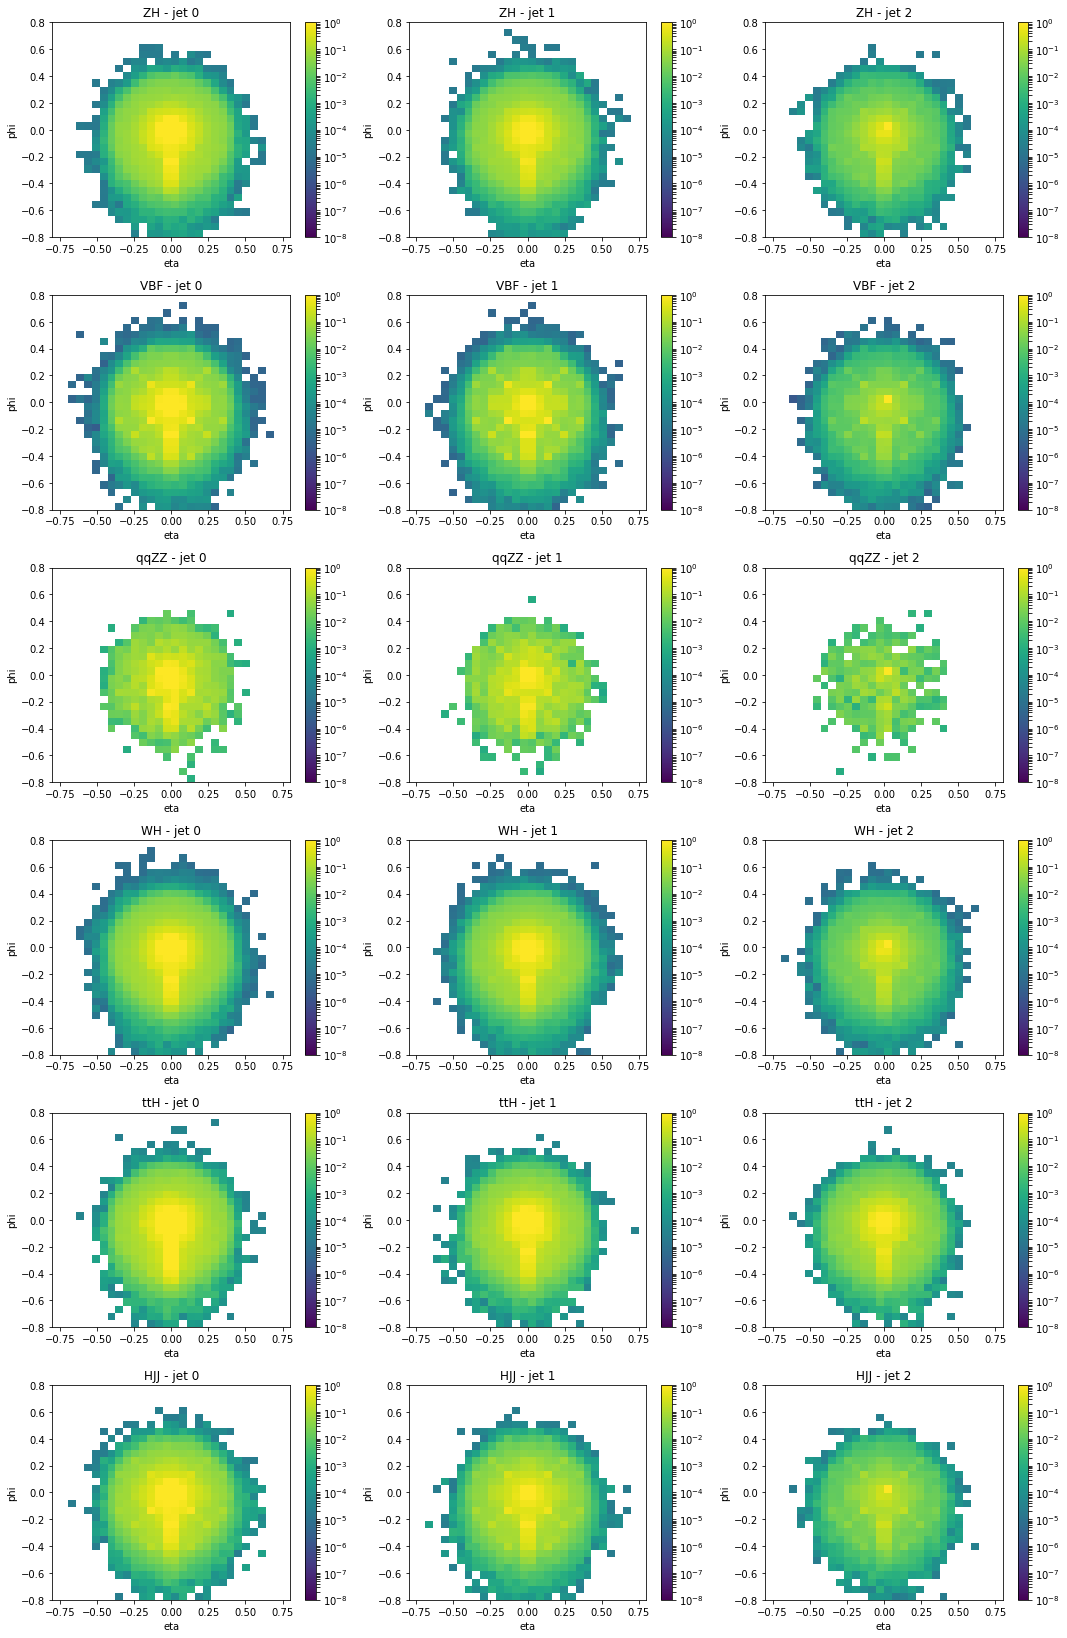

ZH  has  8908  figures...
VBF  has  38014  figures...
qqZZ  has  209  figures...
WH  has  21200  figures...
ttH  has  4253  figures...
HJJ  has  7203  figures...


In [10]:
fig = pyp.figure()
fig.set_figheight(30)
fig.set_figwidth(15)

#defines pixels
nx = 30
ny = 30
proc = [True,True,False,False]

jets_images = {}
lists_x = {}
lists_y = {}
lists_w = {}
xbins = {}
ybins = {}

ip = 0
for ik in events:
    jets_images[ik] = []
    lists_x[ik] = []
    lists_y[ik] = []
    lists_w[ik] = []
    xbins[ik] = []
    ybins[ik] = []

    #create and show jet images
    jets_images[ik], lists_x[ik], lists_y[ik], lists_w[ik], xbins[ik], ybins[ik] = prepareImages(events, ik, nx, -0.8, 0.8, ny, -0.8, 0.8, proc)

    for ich in range(3):
        all_x = np.concatenate(lists_x[ik][ich])
        all_y = np.concatenate(lists_y[ik][ich])
        all_w = np.concatenate(lists_w[ik][ich])
        all_w = 1.*all_w/len(lists_w[ik][ich]) # to get average

        ip += 1
        fig.add_subplot(8, 3, ip)
        pyp.hist2d(all_x, all_y, weights=all_w, bins=(xbins[ik],ybins[ik]), norm=mpl.colors.LogNorm(), vmin=1.e-8, vmax=1)
        pyp.colorbar()
        pyp.xlabel('eta')
        pyp.ylabel('phi')
        pyp.title( '%s - jet %i' % (ik,ich) )

pyp.tight_layout()
fig = pyp.show()

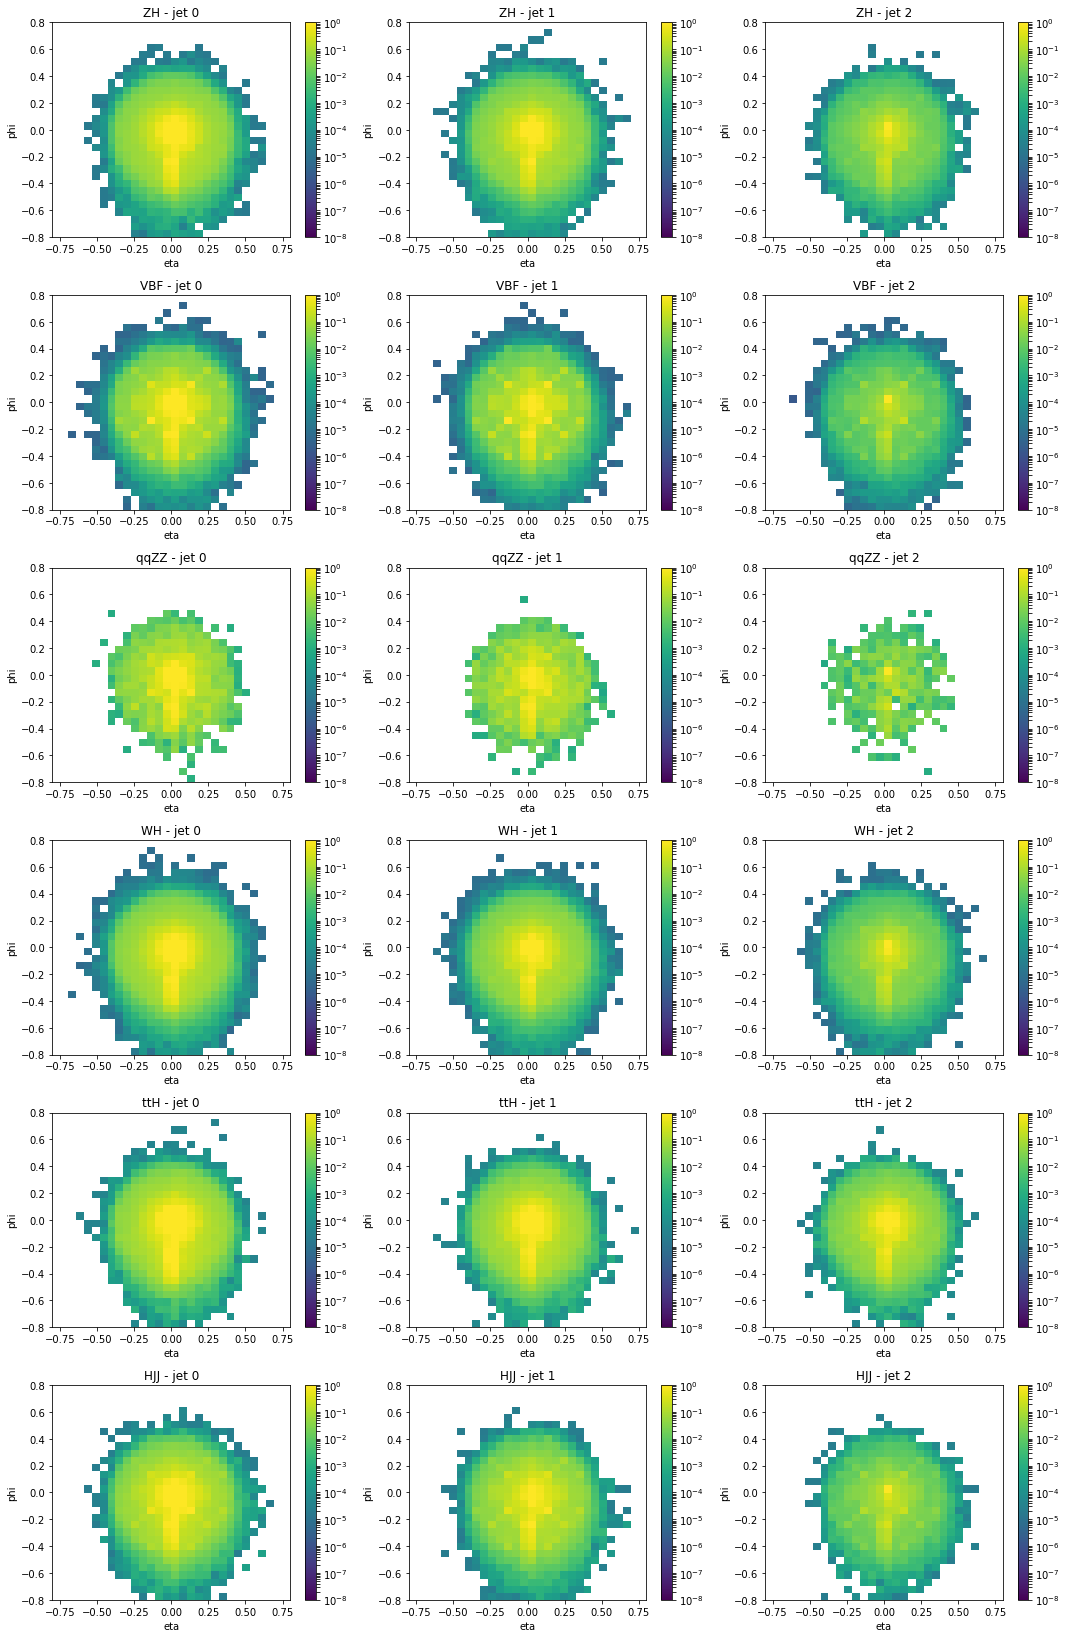

ZH  has  8908  figures...
VBF  has  38014  figures...
qqZZ  has  209  figures...
WH  has  21200  figures...
ttH  has  4253  figures...
HJJ  has  7203  figures...


In [11]:
fig = pyp.figure()
fig.set_figheight(30)
fig.set_figwidth(15)

#defines pixels
nx = 30
ny = 30
proc = [True,True,True,False]

jets_images = {}
lists_x = {}
lists_y = {}
lists_w = {}
xbins = {}
ybins = {}

ip = 0
for ik in events:
    jets_images[ik] = []
    lists_x[ik] = []
    lists_y[ik] = []
    lists_w[ik] = []
    xbins[ik] = []
    ybins[ik] = []

    #create and show jet images
    jets_images[ik], lists_x[ik], lists_y[ik], lists_w[ik], xbins[ik], ybins[ik] = prepareImages(events, ik, nx, -0.8, 0.8, ny, -0.8, 0.8, proc)

    for ich in range(3):
        all_x = np.concatenate(lists_x[ik][ich])
        all_y = np.concatenate(lists_y[ik][ich])
        all_w = np.concatenate(lists_w[ik][ich])
        all_w = 1.*all_w/len(lists_w[ik][ich]) # to get average

        ip += 1
        fig.add_subplot(8, 3, ip)
        pyp.hist2d(all_x, all_y, weights=all_w, bins=(xbins[ik],ybins[ik]), norm=mpl.colors.LogNorm(), vmin=1.e-8, vmax=1)
        pyp.colorbar()
        pyp.xlabel('eta')
        pyp.ylabel('phi')
        pyp.title( '%s - jet %i' % (ik,ich) )

pyp.tight_layout()
fig = pyp.show()

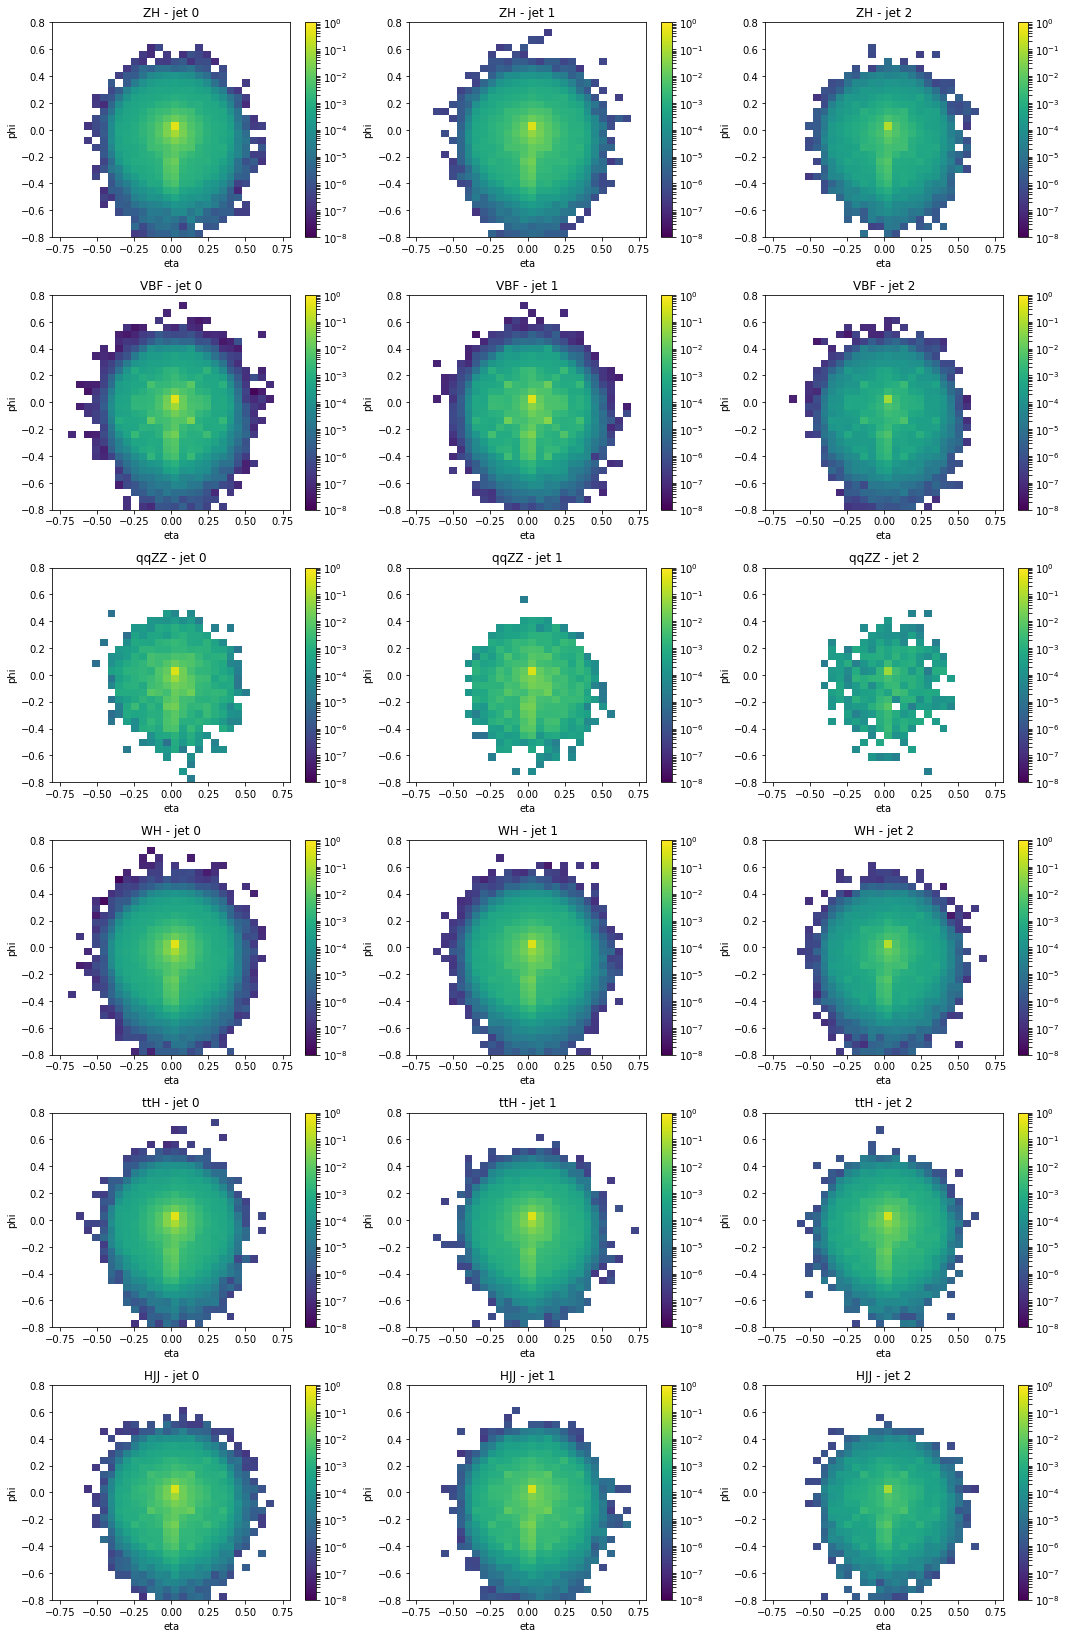

ZH  has  8908  figures...
VBF  has  38014  figures...
qqZZ  has  209  figures...
WH  has  21200  figures...
ttH  has  4253  figures...
HJJ  has  7203  figures...


In [12]:
fig = pyp.figure()
fig.set_figheight(30)
fig.set_figwidth(15)

#defines pixels
nx = 30
ny = 30
proc = [True,True,True,True]

jets_images = {}
lists_x = {}
lists_y = {}
lists_w = {}
xbins = {}
ybins = {}

ip = 0
for ik in events:
    jets_images[ik] = []
    lists_x[ik] = []
    lists_y[ik] = []
    lists_w[ik] = []
    xbins[ik] = []
    ybins[ik] = []

    #create and show jet images
    jets_images[ik], lists_x[ik], lists_y[ik], lists_w[ik], xbins[ik], ybins[ik] = prepareImages(events, ik, nx, -0.8, 0.8, ny, -0.8, 0.8, proc)

    for ich in range(3):
        all_x = np.concatenate(lists_x[ik][ich])
        all_y = np.concatenate(lists_y[ik][ich])
        all_w = np.concatenate(lists_w[ik][ich])
        all_w = 1.*all_w/len(lists_w[ik][ich]) # to get average

        ip += 1
        fig.add_subplot(8, 3, ip)
        pyp.hist2d(all_x, all_y, weights=all_w, bins=(xbins[ik],ybins[ik]), norm=mpl.colors.LogNorm(), vmin=1.e-8, vmax=1)
        pyp.colorbar()
        pyp.xlabel('eta')
        pyp.ylabel('phi')
        pyp.title( '%s - jet %i' % (ik,ich) )

pyp.tight_layout()
fig = pyp.show()

In [13]:
# Model
def build_conv_model():
    input_layer = Input(shape=(3, nx, ny))
    layer = Convolution2D(8, (11, 11), padding='same')(input_layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Convolution2D(8, (3, 3), padding='same')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Convolution2D(8, (3, 3), padding='same')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(20)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

conv_model = build_conv_model()
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 30, 30)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 30, 30)         2912      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 30, 30)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 15, 15)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 15, 15)         584       
_________________________________________________________________
activation_2 (Activation)    (None, 8, 15, 15)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 5, 5)           0         
__________

/lustrehome/mmelodea/virtualenv-1.9/keras/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_1)`


In [14]:
#prepare inputs for model
X = np.concatenate([jets_images['VBF'], jets_images['HJJ'], jets_images['qqZZ'], jets_images['ZH'], jets_images['WH'], jets_images['ttH']])
jets_images_b = np.concatenate([jets_images['HJJ'], jets_images['qqZZ'], jets_images['ZH'], jets_images['WH'], jets_images['ttH']])
Ys = np.ones(jets_images['VBF'].shape[0])
Yb = np.zeros(jets_images_b.shape[0])
Y = np.concatenate([Ys, Yb])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Train and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    conv_model = build_conv_model()
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), epochs=10, batch_size=128, verbose=1, callbacks=[early_stopping])
    Y_score = conv_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyp.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
pyp.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyp.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver operating characteristic example')
pyp.legend(loc="lower right")
pyp.show()